In [31]:
# MLP

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [33]:
fpath = "../../data/DNN_data/v2/"

sig_with_artifact = np.load(fpath + "data_with_non_sine_v2_varying" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


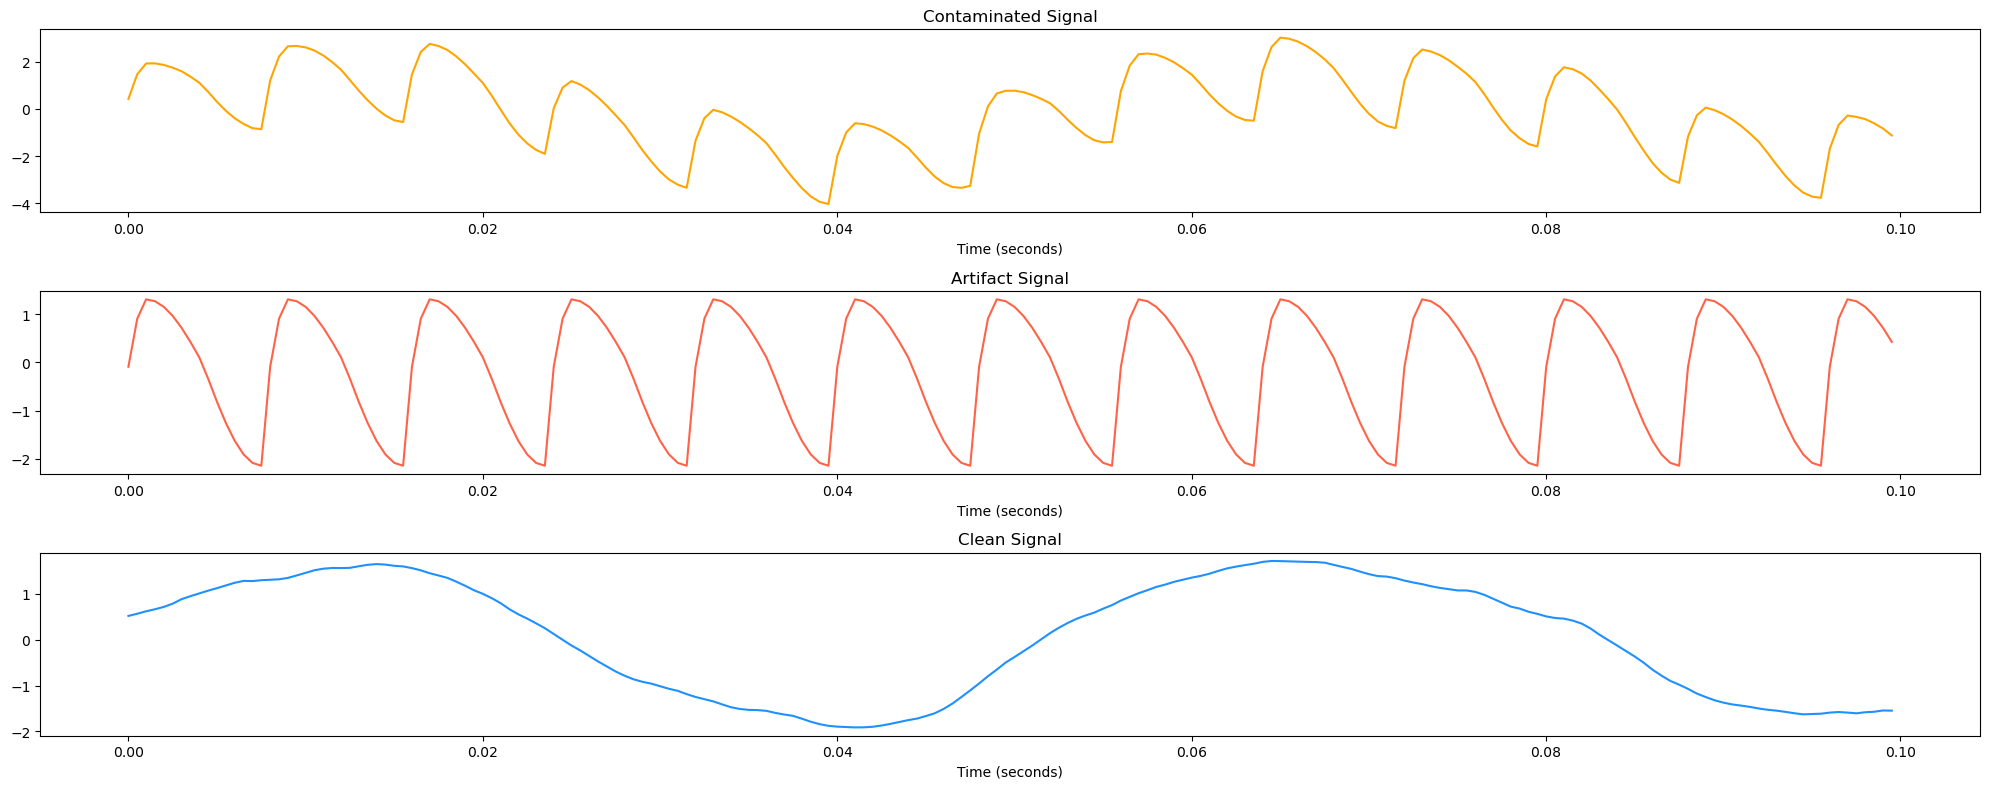

In [34]:
t = np.linspace(0, 2, num=4000) 

plt.figure(figsize=(20,8))
plt.subplot(3, 1, 1)
plt.plot(t[:200], sig_with_artifact[0][:200], color='orange')
plt.xlabel("Time (seconds)")
plt.title('Contaminated Signal')

plt.subplot(3, 1, 2)
plt.plot(t[:200], artifact[0][:200], color='tomato')
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(t[:200], sig[0][:200], color='dodgerblue')
plt.xlabel("Time (seconds)")
plt.title('Clean Signal')

plt.tight_layout()

(1000, 4000)
(1000, 4000)


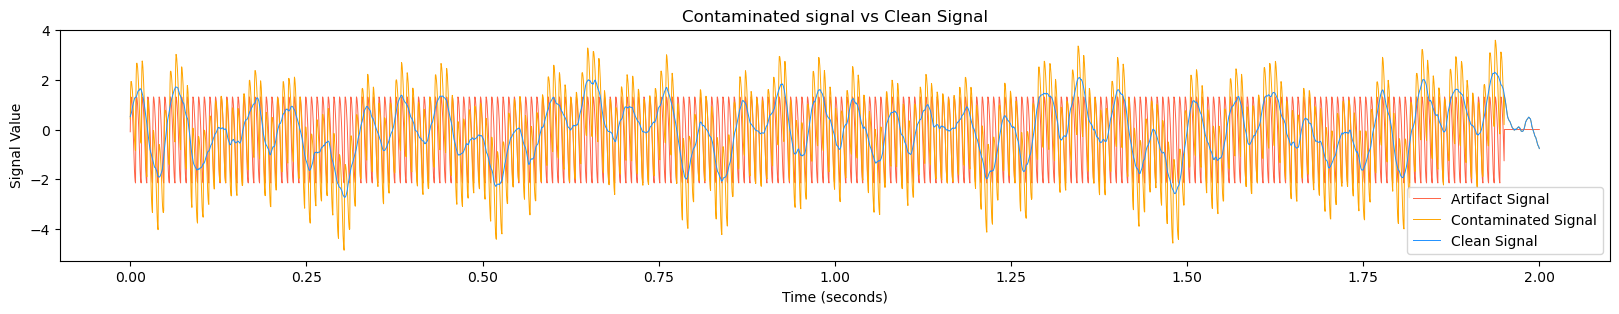

In [35]:
scaler = StandardScaler()

X = scaler.fit_transform(sig_with_artifact.T)
y = (sig.T-scaler.mean_)/np.sqrt(scaler.var_) # X와 동일한 평균, 표준 편차로 scaling

X = X.T
y = y.T

print(X.shape)
print(y.shape)

plt.figure(figsize=(20, 3))
plt.plot(t, artifact[0], label='Artifact Signal', color='tomato', alpha=1, linewidth=0.7)
plt.plot(t, sig_with_artifact[0], label='Contaminated Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(t, sig[0], label='Clean Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Contaminated signal vs Clean Signal')
plt.legend()
plt.show()

In [36]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T, y : B x T
print("X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

# 차원 추가 (MLP는 마지막 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 4000, 1) # B x T x 1
X_test = X_test.reshape(X_test.shape[0], 4000, 1)

print("unsqueezed X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T x 1, y : B x T
print("unsqueezed X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

X_train shape: (800, 4000), y_train shape: (800, 4000)
X_test shape: (200, 4000), y_test shape: (200, 4000)
unsqueezed X_train shape: (800, 4000, 1), y_train shape: (800, 4000)
unsqueezed X_test shape: (200, 4000, 1), y_test shape: (200, 4000)


In [37]:
# 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=1, out_features=256) 
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.drop = nn.Dropout(0.25)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.drop = nn.Dropout(0.25)
        self.fc4 = nn.Linear(in_features=64, out_features=1)


    def forward(self, input_data): # x : B x T x 1
        x = F.gelu(self.fc1(input_data)) # x : B x T x 256
        x = self.drop(x)
        x = F.gelu(self.fc2(x)) # x : B x T x 128
        x = self.drop(x)
        x = F.gelu(self.fc3(x)) # x : B x T x 64
        x = self.drop(x)
        x = self.fc4(x).squeeze(-1) # x : B x T x 1 -> x : B x T
        return x

model = MLP().to(device)
print(model)


MLP(
  (fc1): Linear(in_features=1, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


In [38]:
# 손실 함수 정의
class LossFunction(nn.Module):
    def __init__(self, alpha=0.5):
        super(LossFunction, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

    def forward(self, y_pred, y, y_pred_spectro, y_spectro):
        signal_loss = self.mse_loss(y_pred, y)
        spectrogram_loss = self.mse_loss(y_pred_spectro, y_spectro)
        return self.alpha * signal_loss + (1 - self.alpha) * spectrogram_loss

In [39]:
# 모델 학습
criterion = LossFunction(alpha=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200

for epoch in range(num_epochs):
    for batch in train_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)

        y_pred = model(x) # y_pred : B x T
        
        n = len(y_pred)
        
        y_fft = torch.fft.fft(y)
        y_fft = torch.abs(y_fft[:n//2])
        y_fft[1:] = 2 * y_fft[1:]
        y_spectro = y_fft**2
        
        y_pred_fft = torch.fft.fft(y_pred)
        y_pred_fft = torch.abs(y_pred_fft[:n//2])
        y_pred_fft[1:] = 2 * y_pred_fft[1:]
        y_pred_spectro = y_pred_fft**2
        
        loss = criterion(y_pred, y, y_pred_spectro, y_spectro)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 5/200, Loss: 2498119168.0
Epoch 10/200, Loss: 2178845696.0
Epoch 15/200, Loss: 2239257344.0
Epoch 20/200, Loss: 2044611968.0
Epoch 25/200, Loss: 2334622976.0
Epoch 30/200, Loss: 2173036800.0
Epoch 35/200, Loss: 2398066688.0
Epoch 40/200, Loss: 2276901632.0
Epoch 45/200, Loss: 2390101248.0
Epoch 50/200, Loss: 2277332480.0
Epoch 55/200, Loss: 2055843072.0
Epoch 60/200, Loss: 2363794176.0
Epoch 65/200, Loss: 2355535360.0
Epoch 70/200, Loss: 2034840448.0
Epoch 75/200, Loss: 2175287808.0
Epoch 80/200, Loss: 2272026368.0
Epoch 85/200, Loss: 2298285824.0
Epoch 90/200, Loss: 1948670592.0
Epoch 95/200, Loss: 2228872960.0
Epoch 100/200, Loss: 2282321920.0
Epoch 105/200, Loss: 1838267264.0
Epoch 110/200, Loss: 2281894912.0
Epoch 115/200, Loss: 2344009472.0
Epoch 120/200, Loss: 2176167424.0
Epoch 125/200, Loss: 2313270016.0
Epoch 130/200, Loss: 2173172480.0
Epoch 135/200, Loss: 2099442176.0
Epoch 140/200, Loss: 2354098944.0
Epoch 145/200, Loss: 2351897088.0
Epoch 150/200, Loss: 2121514112.0


In [40]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])
SACed_spectro = torch.tensor([])
Clean_spectro = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)

        y_pred = model(x) # y_pred : B x T

        n = len(y_pred)
        y_fft = torch.fft.fft(y)
        y_fft = torch.abs(y_fft[:n//2])
        y_fft[1:] = 2 * y_fft[1:]
        y_spectro = y_fft**2
        
        y_pred_fft = torch.fft.fft(y_pred)
        y_pred_fft = torch.abs(y_pred_fft[:n//2])
        y_pred_fft[1:] = 2 * y_pred_fft[1:]
        y_pred_spectro = y_pred_fft**2
        loss = criterion(y_pred, y, y_pred_spectro, y_spectro)
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.cpu()), 0)
        Clean = torch.cat((Clean, y.cpu()), 0)
        SACed_spectro = torch.cat((SACed_spectro, y_pred_spectro.cpu()), 0)
        Clean_spectro = torch.cat((Clean_spectro, y_spectro.cpu()), 0)

val_loss = criterion(SACed, Clean, SACed_spectro, Clean_spectro)
print(f'Validation Loss: {val_loss.item()}')    
        

Validation Loss: 2199258880.0


Mean Absolute Error: 1.112869381904602
Mean Squared Error: 1.9883378744125366


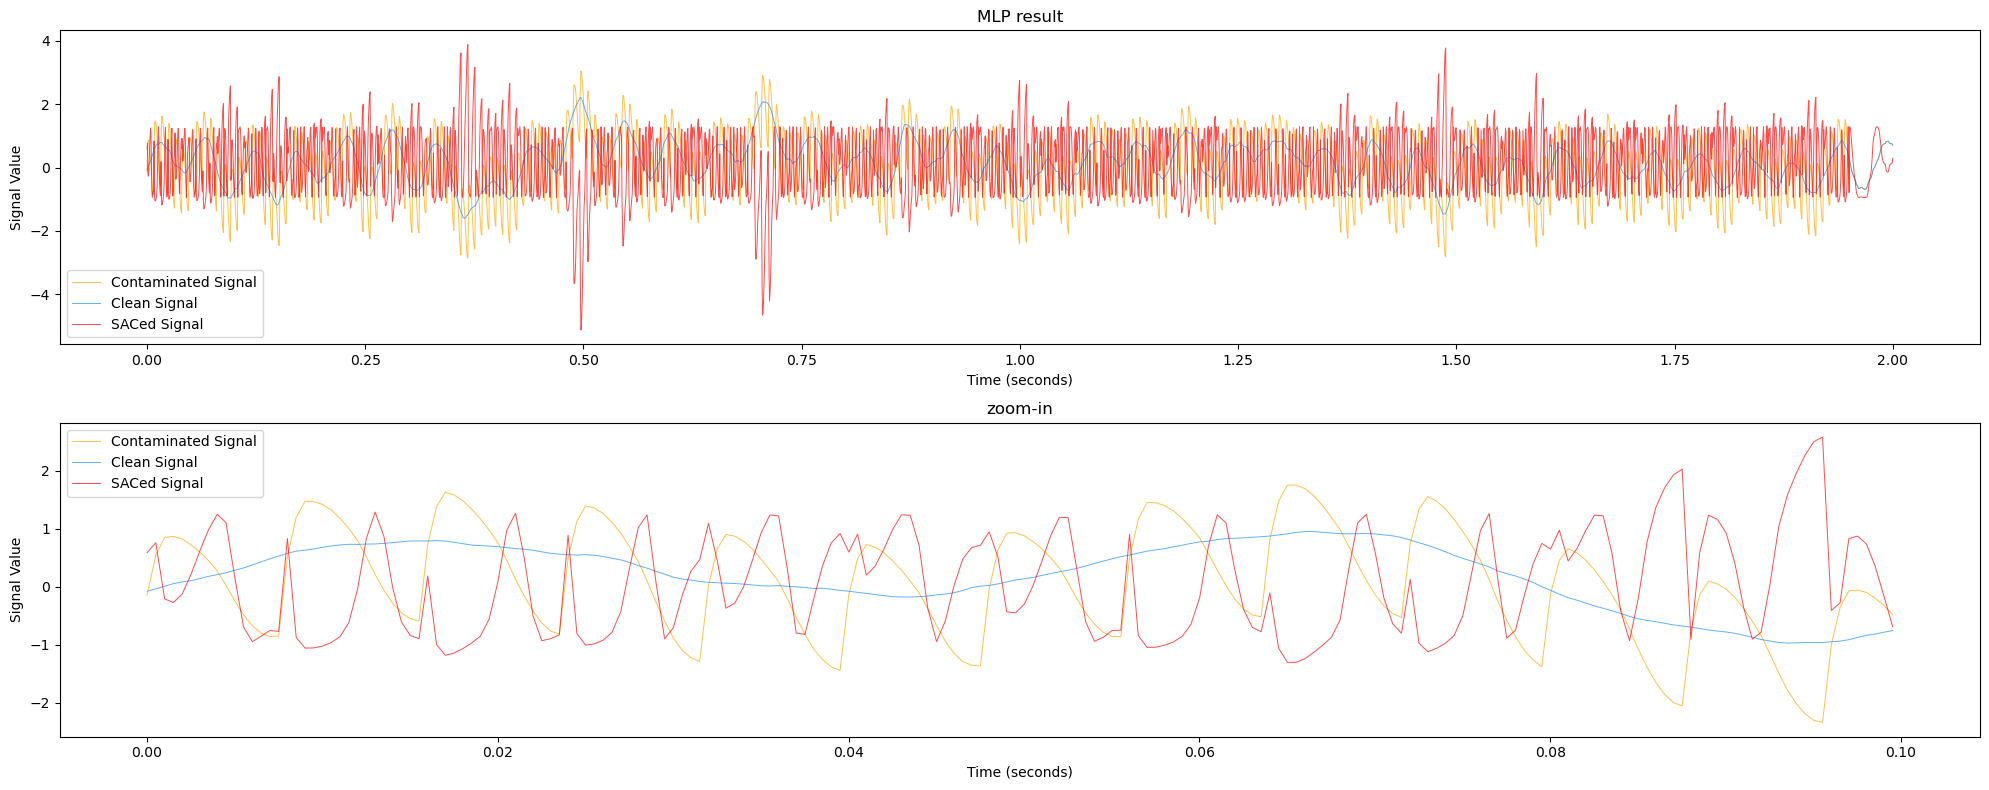

In [41]:
# time domain plotting

Contaminated_signal = Contaminated[0]
SACed_signal = SACed[0]
Clean_signal = Clean[0]

plt.figure(figsize=(20,8))
plt.subplot(2, 1, 1)
plt.plot(t, Contaminated_signal, label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t, Clean_signal, label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t, SACed_signal, label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('MLP result')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[:200], Contaminated_signal[:200], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], Clean_signal[:200], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], SACed_signal[:200], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('zoom-in')
plt.legend()

plt.tight_layout()

print(f"Mean Absolute Error: {mean_absolute_error(Clean_signal, SACed_signal)}")
print(f"Mean Squared Error: {mean_squared_error(Clean_signal, SACed_signal)}")

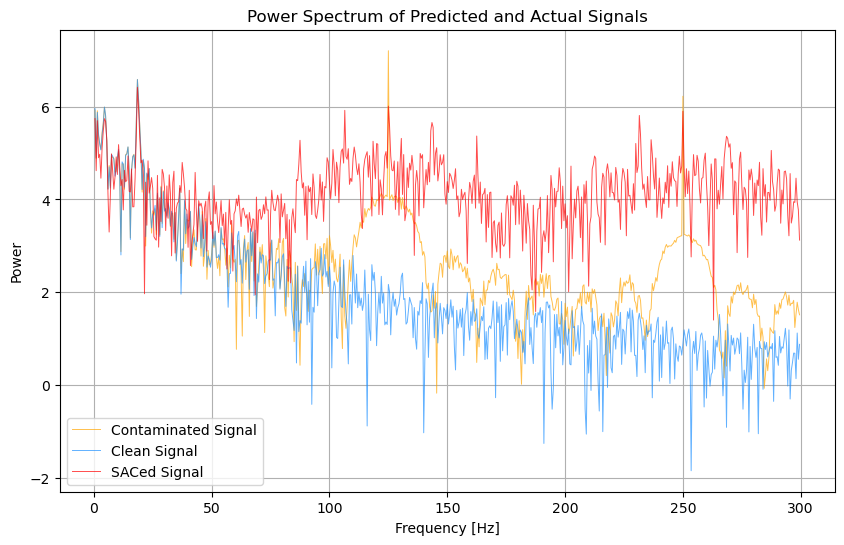

Mean Absolute Error: 2.8227135725010655
Mean Squared Error: 8.945352535237234


In [42]:
# frequency domain plotting

n = len(SACed_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(SACed_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(Clean_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

fft_nonSACed = np.fft.fft(Contaminated_signal)
fft_nonSACed = np.abs(fft_nonSACed[:n//2])
fft_nonSACed[1:] = 2 * fft_nonSACed[1:]
power_nonSACed = fft_nonSACed**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs[1:600], np.log10(power_nonSACed)[1:600], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_actual)[1:600], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_predicted)[1:600], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")